<a href="https://colab.research.google.com/github/ldezhenkong/cs230/blob/master/CS230_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!KAGGLE_USERNAME=lynndzkong KAGGLE_KEY=e17afb0741bbcdc4b38ae1e2fe24b546 kaggle competitions download -c jigsaw-multilingual-toxic-comment-classification

  0% 0.00/3.44M [00:00<?, ?B/s]
100% 3.44M/3.44M [00:00<00:00, 56.5MB/s]
 99% 641M/650M [00:23<00:00, 38.0MB/s]
100% 650M/650M [00:23<00:00, 29.4MB/s]
 89% 33.0M/37.3M [00:00<00:00, 25.1MB/s]
100% 37.3M/37.3M [00:00<00:00, 40.4MB/s]
 30% 9.00M/29.8M [00:00<00:01, 12.8MB/s]
100% 29.8M/29.8M [00:00<00:00, 36.1MB/s]
 98% 287M/292M [00:06<00:00, 32.3MB/s]
100% 292M/292M [00:06<00:00, 45.5MB/s]
  0% 0.00/1.35M [00:00<?, ?B/s]
100% 1.35M/1.35M [00:00<00:00, 43.7MB/s]
 93% 74.0M/79.6M [00:01<00:00, 40.5MB/s]
100% 79.6M/79.6M [00:01<00:00, 44.6MB/s]
  0% 0.00/612k [00:00<?, ?B/s]
100% 612k/612k [00:00<00:00, 83.5MB/s]
 40% 5.00M/12.4M [00:00<00:00, 14.7MB/s]
100% 12.4M/12.4M [00:00<00:00, 28.0MB/s]


In [0]:
!unzip /content/jigsaw-toxic-comment-train.csv.zip
!unzip /content/validation.csv.zip


Archive:  /content/jigsaw-toxic-comment-train.csv.zip
  inflating: jigsaw-toxic-comment-train.csv  
Archive:  /content/validation.csv.zip
  inflating: validation.csv          


In [0]:
!pip install transformers

     |████████████████████████████████| 645kB 2.7MB/s 
     |████████████████████████████████| 1.0MB 13.3MB/s 
     |████████████████████████████████| 890kB 15.9MB/s 
     |████████████████████████████████| 3.8MB 24.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=7e5d985ec34279d1f0c5a59a6c56aebb2eef1b8263ad56800c2a90c30188397b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import os

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import transformers
from tokenizers import BertWordPieceTokenizer
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from tensorflow.keras.callbacks import CSVLogger, Callback, ReduceLROnPlateau


In [0]:
AUTO = tf.data.experimental.AUTOTUNE

EPOCHS = 10
BATCH_SIZE = 32
MAX_LEN = 512

In [0]:
def encode(texts, tokenizer, chunk_size=240, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [0]:
distilbert_version = "distilbert-base-multilingual-cased"
tokenizer_pkg = transformers.DistilBertTokenizer.from_pretrained(distilbert_version)
save_path = "/content/" + distilbert_version + "/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer_pkg.save_pretrained(save_path)
tokenizer = BertWordPieceTokenizer(distilbert_version + "/vocab.txt", lowercase=False)

In [0]:
def get_data(file_path):
  data = pd.read_csv(file_path)
  x = encode(data.comment_text.astype(str), 
                      tokenizer, maxlen=MAX_LEN)
  y = data.toxic.values
  return x, y

In [0]:
x_train, y_train = get_data("jigsaw-toxic-comment-train.csv")
train = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(230)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [0]:
x_valid, y_valid = get_data("validation.csv")
valid = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [0]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.x_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.x_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))

In [0]:
def get_callbacks(log_filepath="log.csv"):
  rocauc = RocAucEvaluation((x_valid, y_valid), interval=1)
  log = CSVLogger(log_filepath)
  reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',  
                                      factor=0.3, patience=3, 
                                      verbose=1, mode='auto', 
                                      epsilon=0.0001, cooldown=1, min_lr=0.000001)

  return [
    reduceLROnPlat,
    log,
    rocauc,
  ]

In [0]:
transformer = transformers.TFDistilBertModel.from_pretrained(distilbert_version)

Bidirectional LSTM from Scratch

In [0]:
input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")

embed = transformer.weights[0].numpy()
rnn_model_scratch = tf.keras.Sequential([
    tf.keras.layers.Embedding(np.shape(embed)[0], np.shape(embed)[1],
                      input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE)),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [0]:
rnn_model_scratch.compile(tf.keras.optimizers.Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [0]:
history = rnn_model_scratch.fit(train, epochs=EPOCHS,
                        steps_per_epoch=BATCH_SIZE, callbacks=get_callbacks("scratch_lstm_log.csv"),
                    validation_data=valid)

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 0.3655 - accuracy: 0.8887
 ROC-AUC - epoch: 1 - score: 0.588017
32/32 [==============================] - 189s 6s/step - loss: 0.3655 - accuracy: 0.8887 - val_loss: 0.4299 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.9062
 ROC-AUC - epoch: 2 - score: 0.573504
32/32 [==============================] - 185s 6s/step - loss: 0.2537 - accuracy: 0.9062 - val_loss: 0.4575 - val_accuracy: 0.8464 - lr: 0.0010
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 0.2382 - accuracy: 0.9199
 ROC-AUC - epoch: 3 - score: 0.577791
32/32 [==============================] - 187s 6s/step - loss: 0.2382 - accuracy: 0.9199 - val_loss: 0.5098 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.9199
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.



In [0]:
rnn_model_scratch_no_train = tf.keras.Sequential([
    tf.keras.layers.Embedding(np.shape(embed)[0], np.shape(embed)[1],
                      input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE)),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [0]:
rnn_model_scratch_no_train.compile(tf.keras.optimizers.Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [0]:
y_pred = rnn_model_scratch_no_train.predict(x_train, verbose=0)
score = accuracy_score(y_train, y_pred)
print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(0, score))

ValueError: ignored

In [0]:
y_pred = rnn_model_scratch_no_train.predict(x_valid, verbose=0)
accuracy = accuracy_score(y_train, y_pred)
score = roc_auc_score(y_valid, y_pred)
print("\n accuracy - epoch: {:d} - score: {:.6f}".format(0, accuracy))
print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(0, score))


 ROC-AUC - epoch: 0 - score: 0.473881


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
x_valid.hist()

AttributeError: ignored

Counter({'tr': 3000, 'es': 2500, 'it': 2500})


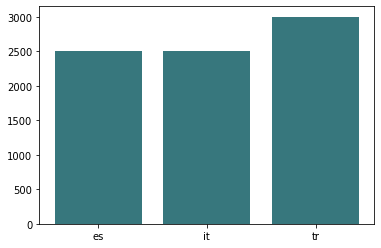

In [0]:
from collections import Counter

data = pd.read_csv("validation.csv")
freqs = Counter(data.lang)
print(freqs)
xvals = range(len(freqs.values()))
plt.bar(xvals, freqs.values() , color='#37777D')
plt.xticks(xvals, freqs.keys())
plt.show() 

### WIP Models below

In [0]:
input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_word_ids")

embed = transformer.weights[0].numpy()
rnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(np.shape(embed)[0], np.shape(embed)[1],
                      input_length=MAX_LEN, weights=[embed],
                      trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE)),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

KeyboardInterrupt: ignored

In [0]:
rnn_model.compile(tf.keras.optimizers.Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [0]:
history = rnn_model.fit(train, epochs=EPOCHS,
                        steps_per_epoch=BATCH_SIZE, callbacks=get_callbacks("pretrained_distilbert_log.csv"),
                    validation_data=valid)

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.1606 - accuracy: 0.9434
 ROC-AUC - epoch: 1 - score: 0.684293
64/64 [==============================] - 170s 3s/step - loss: 0.1606 - accuracy: 0.9434 - val_loss: 0.4604 - val_accuracy: 0.8382 - lr: 0.0100
Epoch 2/10
64/64 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9409
 ROC-AUC - epoch: 2 - score: 0.691071
64/64 [==============================] - 170s 3s/step - loss: 0.1510 - accuracy: 0.9409 - val_loss: 0.4339 - val_accuracy: 0.8224 - lr: 0.0100
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.9448
 ROC-AUC - epoch: 3 - score: 0.679546
64/64 [==============================] - 171s 3s/step - loss: 0.1496 - accuracy: 0.9448 - val_loss: 0.5117 - val_accuracy: 0.7511 - lr: 0.0100
Epoch 4/10
64/64 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.9536
 ROC-AUC - epoch: 4 - score: 0.705230
64/64 [==============================] - 17

Pretrained DistilBert with finetuning

In [0]:
rnn_model_tune = tf.keras.Sequential([
    tf.keras.layers.Embedding(np.shape(embed)[0], np.shape(embed)[1],
                      input_length=MAX_LEN, weights=[embed],
                      trainable=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(BATCH_SIZE)),
    tf.keras.layers.Dense(BATCH_SIZE, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [0]:
rnn_model_tune.compile(tf.keras.optimizers.Adam(lr=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [0]:
history = rnn_model_tune.fit(train, epochs=EPOCHS,
                        steps_per_epoch=BATCH_SIZE, callbacks=get_callbacks("finetune_distilbert_log.csv"),
                    validation_data=valid)

Epoch 1/10
64/64 [==============================] - ETA: 0s - loss: 0.1193 - accuracy: 0.9604

KeyboardInterrupt: ignored